In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
# Load data

# Load your data

from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/MyDrive/train.csv",encoding="utf-8" )
test_df = pd.read_csv("/content/drive/MyDrive/test.csv",encoding="utf-8" )


Mounted at /content/drive


In [4]:
# Convert words and tags to lists
words = list(train_df['Word'].values)
tags = list(train_df['Tag'].values)

In [5]:
print(list(set(train_df["Tag"].values)))

print(list(set(test_df["Tag"].values)))

['O', 'PER', 'LOC']
['O', 'PER', 'LOC']


In [6]:
import pandas as pd

check_for_nan1= pd.isna(train_df).sum()
print(f"Check for Nan in a train dataset using pandas: \n{(check_for_nan1)}")

check_for_nan2= pd.isna(test_df).sum()
print(f"Check for Nan in a test dataset using pandas: \n{(check_for_nan2)}")

Check for Nan in a train dataset using pandas: 
Word    0
Tag     0
dtype: int64
Check for Nan in a test dataset using pandas: 
Sentence #    0
Word          0
Tag           0
dtype: int64


In [7]:
# Split into training and validation sets
words_train, words_val, tags_train, tags_val = train_test_split(words, tags, test_size=0.2, random_state=42)

In [8]:
# Create word and tag indices
unique_words = list(set(words))
unique_tags = list(set(tags))

word2idx = {w: i + 2 for i, w in enumerate(unique_words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

tag2idx = {t: i + 1 for i, t in enumerate(unique_tags)}
tag2idx["PAD"] = 0

idx2tag = {i: w for w, i in tag2idx.items()}

# Convert words and tags to their indices
max_len = 128  # Maximum length of sequences

In [9]:
def encode_data(words, tags, word2idx, tag2idx, max_len):
    X = [word2idx.get(w, word2idx["UNK"]) for w in words]
    y = [tag2idx.get(t, tag2idx["PAD"]) for t in tags]

    X = pad_sequences([X], maxlen=max_len, padding='post', value=word2idx["PAD"])[0]
    y = pad_sequences([y], maxlen=max_len, padding='post', value=tag2idx["PAD"])[0]

    return np.array([X]), np.array([to_categorical(y, num_classes=len(tag2idx))])

X_train, y_train = encode_data(words_train, tags_train, word2idx, tag2idx, max_len)
X_val, y_val = encode_data(words_val, tags_val, word2idx, tag2idx, max_len)

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras.optimizers as optimizers

input = Input(shape=(max_len,))
model = Embedding(input_dim=len(word2idx), output_dim=128, input_length=max_len)(input)
model = Bidirectional(LSTM(units=64, return_sequences=True))(model)
out = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(model)

model = Model(input, out)
Adam=optimizers.Adam(lr=1e-6)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 128, 128)          3031296   
                                                                 
 bidirectional_3 (Bidirecti  (None, 128, 128)          98816     
 onal)                                                           
                                                                 
 time_distributed_3 (TimeDi  (None, 128, 4)            516       
 stributed)                                                      
                                                                 
Total params: 3130628 (11.94 MB)
Trainable params: 3130628 (11.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001, verbose=1)

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    # callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 1.3869 - accuracy: 0.1953 - val_loss: 1.3825 - val_accuracy: 0.3516
Epoch 2/20
1/1 [==============================] - 0s 232ms/step - loss: 1.3759 - accuracy: 0.4297 - val_loss: 1.3780 - val_accuracy: 0.3672
Epoch 3/20
1/1 [==============================] - 0s 228ms/step - loss: 1.3647 - accuracy: 0.5469 - val_loss: 1.3731 - val_accuracy: 0.3984
Epoch 4/20
1/1 [==============================] - 0s 239ms/step - loss: 1.3530 - accuracy: 0.5938 - val_loss: 1.3677 - val_accuracy: 0.4141
Epoch 5/20
1/1 [==============================] - 0s 202ms/step - loss: 1.3403 - accuracy: 0.6250 - val_loss: 1.3617 - val_accuracy: 0.3984
Epoch 6/20
1/1 [==============================] - 0s 259ms/step - loss: 1.3263 - accuracy: 0.6172 - val_loss: 1.3548 - val_accuracy: 0.3672
Epoch 7/20
1/1 [==============================] - 0s 214ms/step - loss: 1.3107 - accuracy: 0.6094 - val_loss: 1.3469 - val_accuracy: 0.3750
Epoch 8/20
1/1 [=======

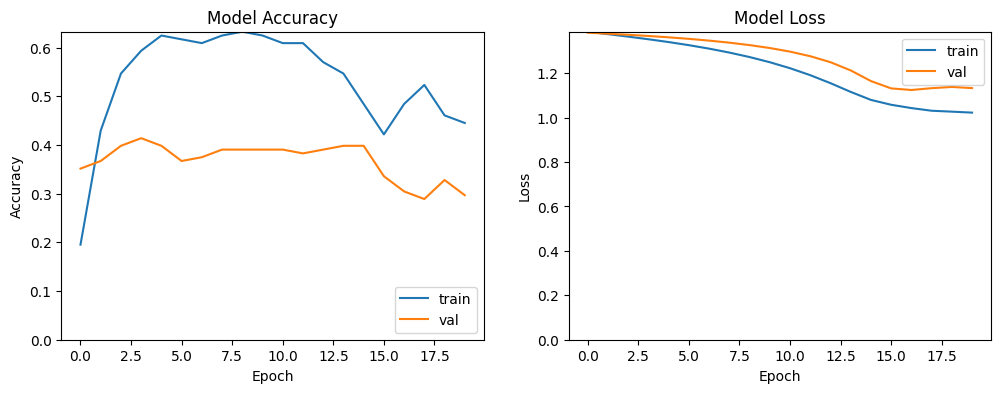

In [31]:
import matplotlib.pyplot as plt

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,max(history.history['accuracy'])])
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'])])
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()


1/1 [==============================] - 0s 38ms/step


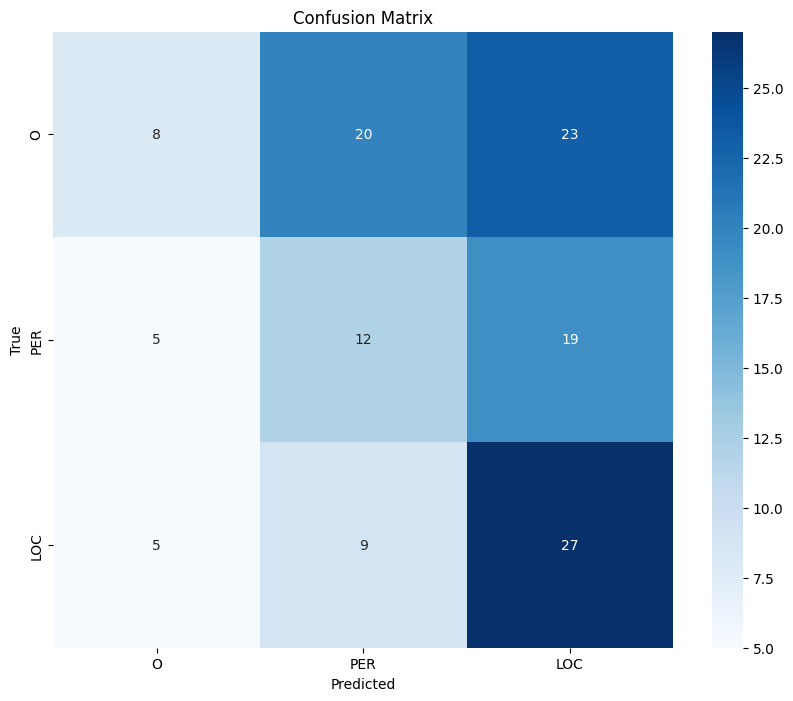

              precision    recall  f1-score   support

           O       0.44      0.16      0.23        51
         PER       0.29      0.33      0.31        36
         LOC       0.39      0.66      0.49        41

    accuracy                           0.37       128
   macro avg       0.38      0.38      0.34       128
weighted avg       0.38      0.37      0.34       128



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = model.predict(X_val).argmax(axis=-1)
y_true = y_val.argmax(axis=-1)

# Flatten the lists to get the true and predicted tags for each word
y_true_flat = [idx2tag[i] for i in y_true.flatten() if i != tag2idx["PAD"]]
y_pred_flat = [idx2tag[i] for i in y_pred.flatten() if i != tag2idx["PAD"]]

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=unique_tags)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_tags, yticklabels=unique_tags)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true_flat, y_pred_flat, labels=unique_tags))
